# Preliminaries

In [38]:
import random
import os
from copy import deepcopy

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pymnet
import powerlaw

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', size=36, **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8
plt.rcParams['savefig.bbox'] = 'tight'

In [3]:
# %matplotlib inline

In [4]:
data_path = 'multiplex_embeddings_data'
datasets_layer_description = {  # {dataset: [layer_1 description, layer_2 description, ...]}
    'Air_Train': [
        'Air network',
        'Train network',
    ],
    'arXiv': [
        'physics.bioph category',
        'cond-mat.disnn category',
        'physics.soc-ph',
        'physics.data-an category',
        'math.OC category',
        'cond-mat.stat-mech category',
        'q-bio.MN category',
        'cs.SI category',
    ],
    'C. Elegans Connectomme': [
        'Electric',
        'Chemical Monadic',
        'Chemical Polyadic',
    ],
    'Drosophila Melanogaster': [  # meh
        'suppressive genetic interaction',
        'additive genetic interaction',
    ],
    'Human Brain': [
        'structural brain network',
        'functional brain network',
    ],
    'IPv4_IPv6 Internet': [  # meh
        'IPv4 topology',
        'IPv6 topology',
    ],
    'Physicians': [
        'advice',
        'discussion',
        'friendship',
    ],
    'Rattus': [  # meh
        'physical association',
        'direct interaction',
    ],
    'SacchPomb': [
        'direct interaction',
        'colocalization',
        'physical association',
        'synthetic genetic interaction',
        'association',
    ],
    'London_Multiplex_Transport': [
        'Tube (All underground lines aggregated)',
        'Overground',
        'DLR',
    ],
    'NYClimateMarch2014_Multiplex_Social': [
        'RT',
        'MT',
        'RE',
    ],
    'Cannes2013_Multiplex_Social': [
        'RT',
        'MT',
        'RE',
    ],
    'MoscowAthletics2013_Multiplex_Social': [
        'RT',
        'MT',
        'RE',
    ],
    'MLKing2013_Multiplex_Social': [
        'RT',
        'MT',
        'RE',
    ],
    'ObamaInIsrael2013_Multiplex_Social': [
        'RT',
        'MT',
        'RE',
    ],
    'CS-Aarhus_Multiplex_Social': [
        'lunch',
        'facebook',
        'coauthor',
        'leisure',
        'work',
    ],
    'Arabidopsis_Multiplex_Genetic': [
        'direct_interaction',
        'physical_association',
        'additive_genetic_interaction_defined_by_inequality',
        'suppressive_genetic_interaction_defined_by_inequality',
        'synthetic_genetic_interaction_defined_by_inequality',
        'association',
        'colocalization',
    ],
    'Bos_Multiplex_Genetic': [
        'physical_association',
        'association',
        'direct_interaction',
        'colocalization',
    ],
    'Celegans_Multiplex_Genetic': [
        'direct_interaction',
        'physical_association',
        'additive_genetic_interaction_defined_by_inequality',
        'suppressive_genetic_interaction_defined_by_inequality',
        'association',
        'colocalization',
    ],
    'Drosophila_Multiplex_Genetic': [
        'direct_interaction',
        'suppressive_genetic_interaction_defined_by_inequality',
        'additive_genetic_interaction_defined_by_inequality',
        'physical_association',
        'colocalization',
        'association',
        'synthetic_genetic_interaction_defined_by_inequality',
    ],
    'SacchCere_Multiplex_Genetic': [
        'physical_association',
        'suppressive_genetic_interaction_defined_by_inequality',
        'direct_interaction',
        'synthetic_genetic_interaction_defined_by_inequality',
        'association',
        'colocalization',
        'additive_genetic_interaction_defined_by_inequality',
    ],
    'YeastLandscape_Multiplex_Genetic': [
        'positive_interactions',
        'negative_interactions',
        'positive_correlations',
        'negative_correlations',
    ],
    'CovMulNet19': [
        'COVID19-GDDS332',
        'COVID19-GDDS457',
    ],
    'arXiv-Netscience_Multiplex_Coauthorship': [
        'physics.soc-ph',
        'physics.data-an',
        'physics.bio-ph',
        'math-ph',
        'math.OC',
        'cond-mat.dis-nn',
        'cond-mat.stat-mech',
        'q-bio.MN',
        'q-bio',
        'q-bio.BM',
        'nlin.AO',
        'cs.SI',
        'cs.CV',
    ],
    'air_data': [
        'Lufthansa',
        'Ryanair',
        'Easyjet',
        'Airways',
        'Airlines',
        'Berlin',
        'France',
        'Airlines',
        'KLM',
        'Alitalia',
        'Lines',
        'Iberia',
        'Shuttle',
        'Airlines',
        'Flybe',
        'Air',
        'Portugal',
        'Airlines',
        'Finnair',
        'Airlines',
        'Airlines',
        'Nostrum',
        'Lingus',
        'Germanwings',
        'Airlines',
        'Netjets',
        'Holland',
        'Niki',
        'SunExpress',
        'Airlines',
        'Airlines',
        'Transport',
        'Airlines',
        'Baltic',
        'Wideroe',
        'Airways',
        'Air',
    ],
}
dataset_names = list(datasets_layer_description.keys())
datasets_layer_description, dataset_names

({'Air_Train': ['Air network', 'Train network'],
  'arXiv': ['physics.bioph category',
   'cond-mat.disnn category',
   'physics.soc-ph',
   'physics.data-an category',
   'math.OC category',
   'cond-mat.stat-mech category',
   'q-bio.MN category',
   'cs.SI category'],
  'C. Elegans Connectomme': ['Electric',
   'Chemical Monadic',
   'Chemical Polyadic'],
  'Drosophila Melanogaster': ['suppressive genetic interaction',
   'additive genetic interaction'],
  'Human Brain': ['structural brain network', 'functional brain network'],
  'IPv4_IPv6 Internet': ['IPv4 topology', 'IPv6 topology'],
  'Physicians': ['advice', 'discussion', 'friendship'],
  'Rattus': ['physical association', 'direct interaction'],
  'SacchPomb': ['direct interaction',
   'colocalization',
   'physical association',
   'synthetic genetic interaction',
   'association'],
  'London_Multiplex_Transport': ['Tube (All underground lines aggregated)',
   'Overground',
   'DLR'],
  'NYClimateMarch2014_Multiplex_Social': [

In [5]:
def random_relabel(G):
    nodes = list(G.nodes)
    random.shuffle(nodes)
    return nx.relabel_nodes(G, dict(zip(G.nodes, nodes)))

In [6]:
def find_component(node, connected_components):
    for i, component in enumerate(connected_components):
        if node in component:
            return i
    raise ValueError(f'Component for node {node} not found')

In [7]:
def cascade_remove_links(G):

    keep_going = True
    while keep_going:
        keep_going = False

        clusters_in_layers = [list(nx.connected_components(g)) for g in G]

        for i, g in enumerate(G):
            clusters_to_search = clusters_in_layers[:i] + clusters_in_layers[i + 1:]
            for edge in g.edges():
                if any(find_component(edge[0], clusters) != find_component(edge[1], clusters)
                       for clusters in clusters_to_search):
                    keep_going = True
                    g.remove_edge(*edge)
    
    return G

In [8]:
def articulation_points_multiplex(G):
    ap = set(nx.articulation_points(G[0]))
    return ap.union(*[nx.articulation_points(g) for g in G[1:]])

In [9]:
def max_comp(g):
    return max(nx.connected_components(g), key=len)

In [10]:
def remove_ap(G):
    G = cascade_remove_links(G)

    gcc = max_comp(G[0])
    gcc_size = len(gcc)

    for g in G:
        g.remove_nodes_from([n for n in g if n not in gcc])

    art_points = articulation_points_multiplex(G)

    for g in G:
        g.remove_nodes_from(art_points)

    return G, art_points, gcc_size

In [11]:
def draw_two_layer(G_orig, G, layer_labels, show_labels, pos, ax):
    """Supports only one or two layers
    """
    onet = pymnet.MultiplexNetwork(couplings='categorical')
    for label in layer_labels:
        onet.add_layer(label)
    L = len(layer_labels)

    GRAY = '#84817a'
    BLACK = '#485460'

    art_points = articulation_points_multiplex(G)
    removed = [n for n in G_orig[0] if n not in G[0]]
    node_colors = {(node, layer): 'r'
                   for layer in layer_labels
                   for node in art_points}
    node_colors.update({(node, layer): GRAY
                        for layer in layer_labels
                        for node in removed})
    edge_colors = {}
    edge_alpha = {}
    edge_width = {}

    for n in G_orig[0].nodes:
        onet.add_node(n)
        if L == 2:
            edge_width[((n, layer_labels[0]), (n, layer_labels[1]))] = .2

    for label, g in zip(layer_labels, G_orig):
        for e1, e2 in g.edges:
            onet[e1, e2, label] = 1
            if e1 in removed or e2 in removed:
                # edge_colors[((e1, 'Facebook'), (e2, 'Facebook'))] = GRAY
                edge_alpha[((e1, label), (e2, label))] = .3
                # edge_width[((e1, 'Facebook'), (e2, 'Facebook'))] = .2
            else:
                # edge_width[((e1, 'Facebook'), (e2, 'Facebook'))] = .5
                edge_colors[((e1, label), (e2, label))] = BLACK

    return pymnet.draw(
        onet,
        elev=20,
        layergap=1.35,
        camera_dist=10,
        figsize=(24, 8),
        nodeCoords=pos,
        ax=ax,
        defaultLayerColor='#e8f8f8',
        # defaultLayerColor='#81ecec',
        # defaultLayerColor='#dff9fb',
        layerLabelDict={} if show_labels else {lbl: '' for lbl in layer_labels},
        defaultLayerLabelLoc=(.7, 1),
        defaultLayerLabelSize=20,
        nodeLabelRule={},
        nodeColorDict=node_colors,
        edgeColorDict=edge_colors,
        # edgeWidthDict=edge_width,
        defaultEdgeWidth=.1,
        edgeAlphaDict=edge_alpha,
    )

In [12]:
def draw_process(G, pos, layer_labels, figtitle):
    plt.close('all')
    G_orig = deepcopy(G)
    ap_steps = []

    while True:
        G = cascade_remove_links(G)
        gcc = max_comp(G[0])
        for g in G:
            g.remove_nodes_from([n for n in g if n not in gcc])

        ap_steps.append(deepcopy(G))

        art_points = articulation_points_multiplex(G)
        for g in G:
            g.remove_nodes_from(art_points)
        if not art_points:
            break

    fig, ax = plt.subplots(nrows=1, ncols=len(ap_steps), squeeze=False,
                           subplot_kw=dict(projection='3d'),
                           figsize=(24, 6),
                           layout='constrained')
    letters = iter('abcdefghijklmnopqrstuvwxyz')
    for i in range(len(ap_steps)):
        draw_two_layer(G_orig, ap_steps[i], layer_labels, i == 0, pos, ax[0, i])
        ax[0, i].text(-.4, .45, 1, fr'$\mathrm{{({next(letters)})}}$')
    fig.draw_without_rendering()
    fig.savefig(figtitle)

In [13]:
plt.close('all')

# Load dataset

In [14]:
len(dataset_names)

25

In [16]:
dataset_name = dataset_names[6]
random_relabeling = False

In [17]:
print(f'Loading {dataset_name}')
path = os.path.join(data_path, dataset_name)

layer_paths = [
    os.path.join(path, f'l_{i}.txt')
    for i in range(1, len(datasets_layer_description[dataset_name]) + 1)
]
G_loaded = [nx.read_edgelist(
    layer_path,
    create_using=nx.Graph,
    nodetype=int,
) for layer_path in layer_paths]

if random_relabeling:
    for i, g in enumerate(G_loaded[1:]):
        G_loaded[i + 1] = random_relabel(g)
print(*G_loaded, sep='\n')

Loading Physicians
Graph with 215 nodes and 449 edges
Graph with 231 nodes and 498 edges
Graph with 228 nodes and 423 edges


# Preprocessing

In [133]:
# G = [deepcopy(g) for g in G_loaded if len(g) > 100]
# G = [g for g in G_loaded if len(g.edges) > 8000]
G = [deepcopy(G_loaded[1]), deepcopy(G_loaded[2])]
print(*G, sep='\n')

Graph with 231 nodes and 498 edges
Graph with 228 nodes and 423 edges


In [134]:
# for g in G:
#     g.remove_nodes_from([n for n in g if len(g[n]) < 3])
# print(*G, sep='\n')

In [135]:
possible_nodes = set(G[0].nodes).union(
    *(set(g.nodes) for g in G[1:]),
)
real_nodes = possible_nodes.intersection(*(g.nodes for g in G))

print(f'Only {len(real_nodes)} real nodes that are present in all layers')

Only 218 real nodes that are present in all layers


In [136]:
print(f'Dropping {len(possible_nodes) - len(real_nodes)} redundant nodes')
for g in G:
    g.remove_nodes_from([n for n in g if n not in real_nodes])

Dropping 23 redundant nodes


Layer 1:
  Size: 218
  Edges: 469
  Mean degree: 4.302752293577981
Layer 2:
  Size: 218
  Edges: 395
  Mean degree: 3.623853211009174


C:\Users\kuzne\AppData\Local\Temp\ipykernel_18296\2479956608.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


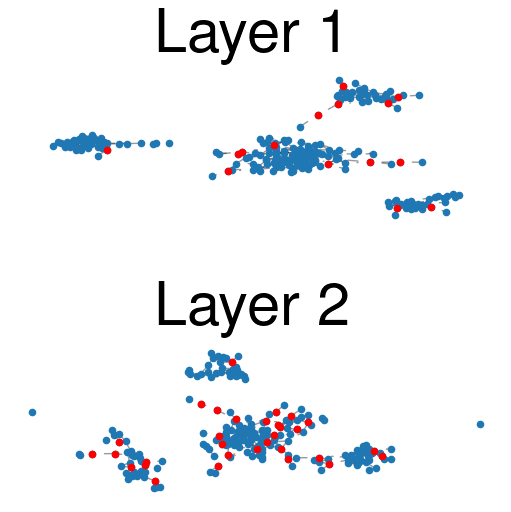

In [137]:
%matplotlib inline
fig, ax = plt.subplots(nrows=len(G), ncols=1, figsize=(6, 3 * len(G)))
for i, g in enumerate(G):

    print(f'Layer {i + 1}:')
    print(f'  Size: {len(g)}')
    print(f'  Edges: {len(g.edges)}')

    degree_sequence = sorted((d for _, d in g.degree), reverse=True)
    print(f'  Mean degree: {np.mean(degree_sequence)}')

    # sorted_nodes = sorted(g.nodes)
    # mn, mx = sorted_nodes[0], sorted_nodes[-1]
    # if all(n1 == n2 for n1, n2 in zip(sorted_nodes, range(mn, mx + 1))):
    # # if sorted_nodes == list(range(mn, mx + 1)):
    #     print(f'  Nodes are labeled through {mn}:{mx}')
    # else:
    #     gaps = [n for n in range(mn, mx + 1) if n not in sorted_nodes]
    #     print(f'  Nodes are labeled through {mn}:{mx} with {len(gaps)} gaps {gaps}')
    
    # ax[i, 0].set_title('Degree distribution')
    # ax[i, 0].bar(*np.unique(degree_sequence, return_counts=True), width=.8)

    # ax[i, 1].set_title('Degree distribution (log)')
    # ax[i, 1].hist(degree_sequence, bins=np.logspace(np.log10(1), np.log10(len(g)), num=len(g)), rwidth=.8)
    # # ax[i, 1].hist(degree_sequence, bins=len(g), rwidth=.8)
    # ax[i, 1].set_xscale('log')
    # ax[i, 1].set_yscale('log')
    # # ax2.plot(np.exp(np.arange(1, np.log10(len(G)))), 1000 - 2.5 * np.exp(np.arange(1, np.log10(len(G)))))

    if len(g) < 1000:
        ax[i].set_title(f'Layer {i + 1}')
        # gcc = g.subgraph(sorted(nx.connected_components(g), key=len, reverse=True)[0])
        # pos = nx.kamada_kawai_layout(g)
        pos = nx.spring_layout(g)
        nx.draw_networkx_nodes(g, pos, ax=ax[i], node_size=20)
        ap = nx.articulation_points(g)
        nx.draw_networkx_nodes(g.subgraph(ap), pos, ax=ax[i], node_size=20, node_color='r')
        nx.draw_networkx_edges(g, pos, ax=ax[i], alpha=.4, arrows=True)
        ax[i].set_axis_off()

fig.tight_layout()
fig.show()

# Experiment

In [23]:
# G = [nx.erdos_renyi_graph(5000, 3 / 4999),
#      nx.erdos_renyi_graph(5000, 3 / 4999)]

In [ ]:
for i, g in enumerate(G):
    g = nx.relabel_nodes(g, dict(zip(G[0].nodes, range(len(G[0])))))
    nx.write_edgelist(g, f'cpp_data/l_{i + 1}.txt', data=False)

2.737754075101877

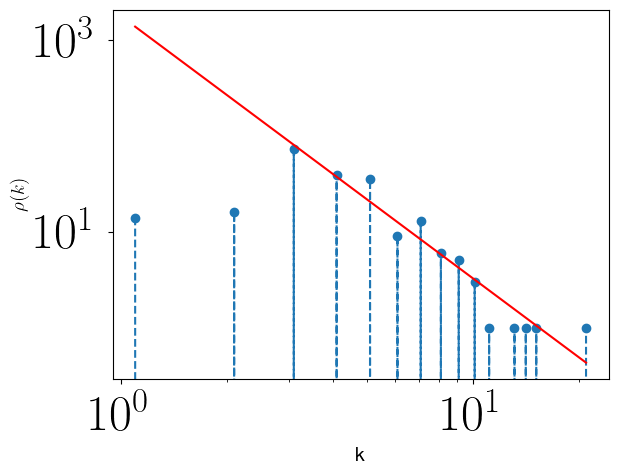

In [138]:
degree = [d for _, d in G[0].degree]
cutoff = 2
h, x = np.histogram(degree, bins=100) 
x_ = (x[:-1]+x[1:]) / 2

z = np.polyfit(np.log(x_[np.nonzero(h)][cutoff:]), np.log(h[np.nonzero(h)][cutoff:]), 1) 
f = np.poly1d(z)

plt.plot(x_, h, 'o--')
plt.plot(x_, np.exp(f(np.log(x_))), color='red')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k', fontsize=14)
plt.ylabel(r'$\rho(k)$', fontsize=14)

lambda1 = -z[0]
lambda1

4.6353991910416354

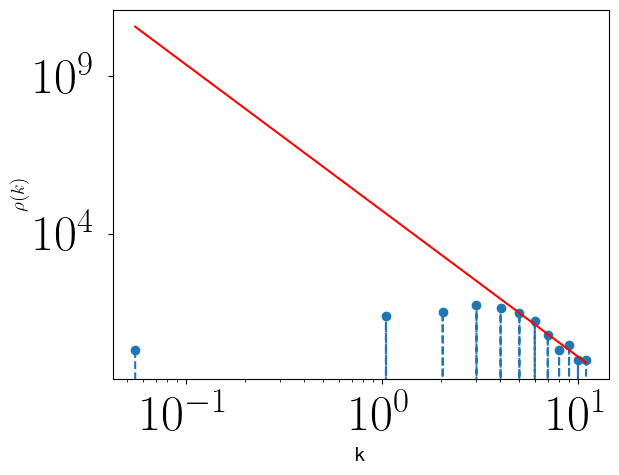

In [139]:
degree = [d for _, d in G[1].degree]
cutoff = 6
h, x = np.histogram(degree, bins=100) 
x_ = (x[:-1]+x[1:]) / 2

z = np.polyfit(np.log(x_[np.nonzero(h)][cutoff:]), np.log(h[np.nonzero(h)][cutoff:]), 1) 
f = np.poly1d(z)

plt.plot(x_, h, 'o--')
plt.plot(x_, np.exp(f(np.log(x_))), color='red')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k', fontsize=14)
plt.ylabel(r'$\rho(k)$', fontsize=14)

lambda2 = -z[0]
lambda2

In [140]:
np.mean([d for _, d in G[0].degree]), np.mean([d for _, d in G[1].degree])

(4.302752293577981, 3.623853211009174)

In [141]:
while np.mean([d for _, d in G[0].degree]) < 4.3:
    i = np.random.choice(G[0])
    j = np.random.choice(G[0])
    if (i, j) not in G[0]:
        print(f'adding ({i}, {j}) to layer 1')
        G[0].add_edge(i, j)
while np.mean([d for _, d in G[1].degree]) < 4.3:
    i = np.random.choice(G[1])
    j = np.random.choice(G[1])
    if (i, j) not in G[1]:
        print(f'adding ({i}, {j}) to layer 2')
        G[1].add_edge(i, j)

adding (41, 49) to layer 2
adding (87, 183) to layer 2
adding (60, 101) to layer 2
adding (135, 140) to layer 2
adding (174, 228) to layer 2
adding (108, 217) to layer 2
adding (122, 21) to layer 2
adding (231, 239) to layer 2
adding (190, 13) to layer 2
adding (119, 141) to layer 2
adding (129, 28) to layer 2
adding (144, 114) to layer 2
adding (53, 82) to layer 2
adding (202, 110) to layer 2
adding (222, 218) to layer 2
adding (10, 37) to layer 2
adding (129, 143) to layer 2
adding (186, 222) to layer 2
adding (86, 36) to layer 2
adding (16, 49) to layer 2
adding (227, 133) to layer 2
adding (53, 78) to layer 2
adding (4, 57) to layer 2
adding (217, 12) to layer 2
adding (192, 207) to layer 2
adding (64, 103) to layer 2
adding (20, 174) to layer 2
adding (52, 4) to layer 2
adding (227, 15) to layer 2
adding (106, 128) to layer 2
adding (144, 128) to layer 2
adding (128, 53) to layer 2
adding (224, 169) to layer 2
adding (62, 136) to layer 2
adding (74, 40) to layer 2
adding (74, 171)

In [143]:
np.mean([d for _, d in G[0].degree]), np.mean([d for _, d in G[1].degree])

(4.302752293577981, 4.302752293577981)

In [151]:
G, ap, gcc_size = remove_ap(G)
G, ap, len(ap), gcc_size

([<networkx.classes.graph.Graph at 0x1f99442d810>,
 set(),
 0,
 1)

# Plots

In [ ]:
# G = [
#     nx.Graph([
#         (0, 1), (0, 2), (1, 3), (2, 3), (3, 4), (3, 5),
#         (4, 7), (4, 6), (5, 6), (5, 8), (6, 7), (6, 8), (7, 9), (8, 9),
#         (0, 3), (3, 6), (6, 9),
#     ]),
#     nx.Graph([
#         (0, 1), (0, 2), (1, 3), (2, 3), (3, 4), (3, 5), (1, 4), (2, 5),
#         (4, 6), (5, 6), (6, 7), (6, 8), (7, 9), (8, 9),
#         (0, 3), (3, 6), (6, 9),
#     ]),
# ]

In [59]:
# pos = nx.kamada_kawai_layout(G[0])
pos = nx.kamada_kawai_layout(G[0])
# pos = nx.circular_layout(G[0])
# pos = nx.planar_layout(G[0])
# pos = nx.shell_layout(G[0])
# pos = nx.spring_layout(G[0])
# pos = nx.spring_layout(G[1])

In [79]:
# draw_process(deepcopy(G), pos, ['Lunch', 'Work'], 'figs/real_multiplex_example.pdf')
# draw_process(deepcopy(G), pos, [
#     'Physics: Data Analysis, Statistics and Probability',
#     'CS: Social and Information Networks',
# ], 'figs/real_multiplex_example.pdf')
# draw_process(G, pos, ['IPv4', 'IPv6'], 'figs/internet')

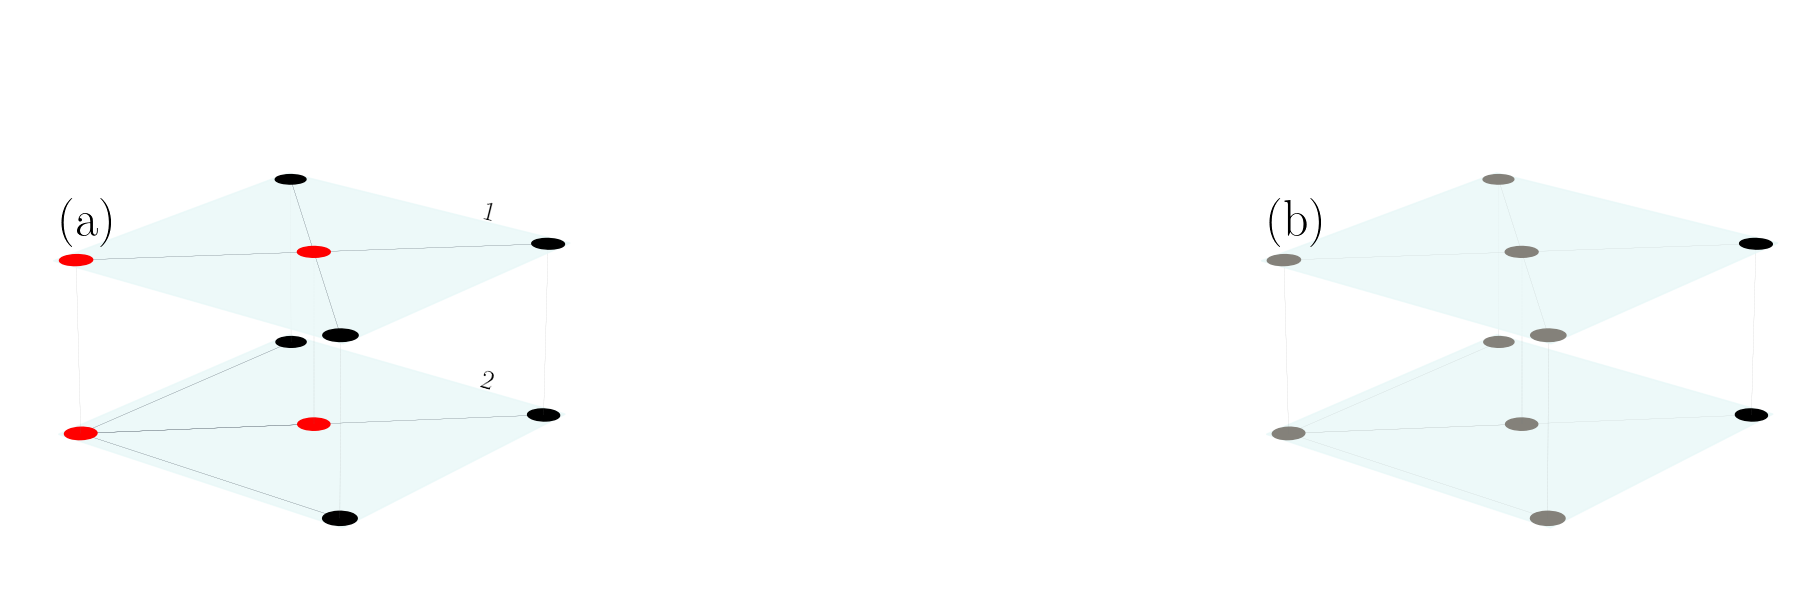

In [60]:
draw_process(
    G, pos,
    [
        '1',
        '2',
    ],
    # 'figs/toy_example/toy_example',
    # 'figs/toy_example/toy_example_1',
    'figs/toy_example/tmp',
)